### Context
Imagine that you are a data scientist working for The Johns Hopkins Hospital. Your team is asked to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine which patients have high stroke risk will allow doctors to advise them and their families on how to act in case of an emergency.

## Initial Setup 
### Package imports

In [57]:
import polars as pl
import numpy as np
import pandas as pd
from skimpy import skim
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from xgboost import XGBRFClassifier
from scipy.stats import pointbiserialr
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
import shap
import plotly.io as pio
import graphviz
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from pyod.models.knn import KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [58]:
from stroke_helper_functions_v2 import (
    make_subplot,
    int_range,
    false_negative_error_rate,
    create_encoder_mapping,
    encode_feature,
    impute_missing_values,
    calculate_model_statistics,
    segment_df_by_gender,
    lgbm_feature_importances,
    false_negative_error_rate,
    create_chi2_array,
    scale_x_array,
    restrict_x_columns,
    rfe_gridsearch_pipeline,
    rerun_models
)

### Settings

In [59]:
pd.set_option("display.float_format", "{:.5f}".format)

warnings.filterwarnings("ignore")

pl.Config.set_tbl_hide_column_data_types(True)

binary_color_map = {0: "rgb(154, 211, 189)", 1: "rgb(58, 121, 136)"}

pio.templates.default = "plotly"
pio.templates["plotly"].layout.update(width=1600, height=750)

global_random_state = 15

## Load data

We'll start by loading in our anonymized patient data to start acquainting ourselves. 

In [60]:
df = pl.read_csv(
    "healthcare-dataset-stroke-data.csv",
    ignore_errors=True,
).rename({"Residence_type": "residence_type"})
df

id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,"""Male""",67,0,1,"""Yes""","""Private""","""Urban""",228.69,"""36.6""","""formerly smoked""",1
51676,"""Female""",61,0,0,"""Yes""","""Self-employed""","""Rural""",202.21,"""N/A""","""never smoked""",1
31112,"""Male""",80,0,1,"""Yes""","""Private""","""Rural""",105.92,"""32.5""","""never smoked""",1
60182,"""Female""",49,0,0,"""Yes""","""Private""","""Urban""",171.23,"""34.4""","""smokes""",1
1665,"""Female""",79,1,0,"""Yes""","""Self-employed""","""Rural""",174.12,"""24""","""never smoked""",1
…,…,…,…,…,…,…,…,…,…,…,…
18234,"""Female""",80,1,0,"""Yes""","""Private""","""Urban""",83.75,"""N/A""","""never smoked""",0
44873,"""Female""",81,0,0,"""Yes""","""Self-employed""","""Urban""",125.2,"""40""","""never smoked""",0
19723,"""Female""",35,0,0,"""Yes""","""Self-employed""","""Rural""",82.99,"""30.6""","""never smoked""",0
37544,"""Male""",51,0,0,"""Yes""","""Private""","""Rural""",166.29,"""25.6""","""formerly smoked""",0


In [61]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5110   │ │ string      │ 6     │                                                          │
│ │ Number of columns │ 12     │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %  ┃ mean     ┃ sd      ┃ p0     ┃ p25    ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ id                  │    0 │     0 │    36520 │   21160 │     67 │  17740 │ 36930 │ 54680 │ 72940 │ ▇▇▇▇▇▇ │  │
│ │ age                 │  115 │  2.25 │     44.2 │   21.94 │      1 │     27 │    45 │    61 │    82 │ ▅▆▇▇▇▆ │  │
│ │ hypertension        │    0 │     0 │  0.09746 │  0.2966 │      0 │      0 │     0 │     0 │     1 │ ▇    ▁ │  │
│ │ heart_disease       │    0 │     0 │  0.05401 │  0.2261 │      0 │      0 │     0 │     0 │     1 │   ▇    │  │
│ │ avg_glucose_level   │    0 │     0 │    106.1 │   45.28 │  55.12 │  77.25 │ 91.88 │ 114.1 │ 271.7 │ ▇▅▁▁▁  │  │
│ │ stroke              │    0 │     0 │  0.04873 │  0.2153 │      0 │      0 │     0 │     0 │     1 │   ▇    │  │
│ └─────────────────────┴──────┴───────┴──────────┴─────────┴────────┴────────┴───────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ gender                        │      0 │          0 │                           1 │                   5110 │  │
│ │ ever_married                  │      0 │          0 │                           1 │                   5110 │  │
│ │ work_type                     │      0 │          0 │                           1 │                   5110 │  │
│ │ residence_type                │      0 │          0 │                           1 │                   5110 │  │
│ │ bmi                           │      0 │          0 │                           1 │                   5110 │  │
│ │ smoking_status                │      0 │          0 │                         1.5 │                   7887 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Our id column is non-sequential, and ranges pretty widely in terms of number of digits as well. Since we don't have patient names or other information to make these numbers meaningful, we should drop this feature, as it is mostly like an atavism from pulling the data from EPIC or whichever other database systems Johns Hopkins uses in their hospitals. Our variables bmi, age, and avg. glucose level are all float or integer ranges, whereas our other features seem to be either boolean or categorical features. Let's look at our null values. 

## Duplicate values


In [62]:
df.is_duplicated().sum()

0

This dataset doesn't have any duplicates. Exploratory analysis showed that even though so many of the values take on binary values, these observations have differing BMI values, which suggests that these are in fact distinct patients. 

## Null values 

In [63]:
df.null_count()

id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,115,0,0,0,0,0,0,0,0,0


We have null values for age, but in the df printout above we can also see N/A values for BMI. We should take a closer look at that since that is also a type of null value for our purposes. 

In [64]:
df.filter(pl.col("bmi") == "N/A").shape

(201, 12)

We can see here that there are 201 rows that have a null value for BMI. Considering that this is a nontrivial amount of null values for these variables, we should impute these values rather than dropping the variable or observations outright. Let's check for balance across our features next, since that has implications for which metrics need to be used as performance benchmarks in our models later. 

## Checking for balance

Let's look at the balance across our categorical variables.

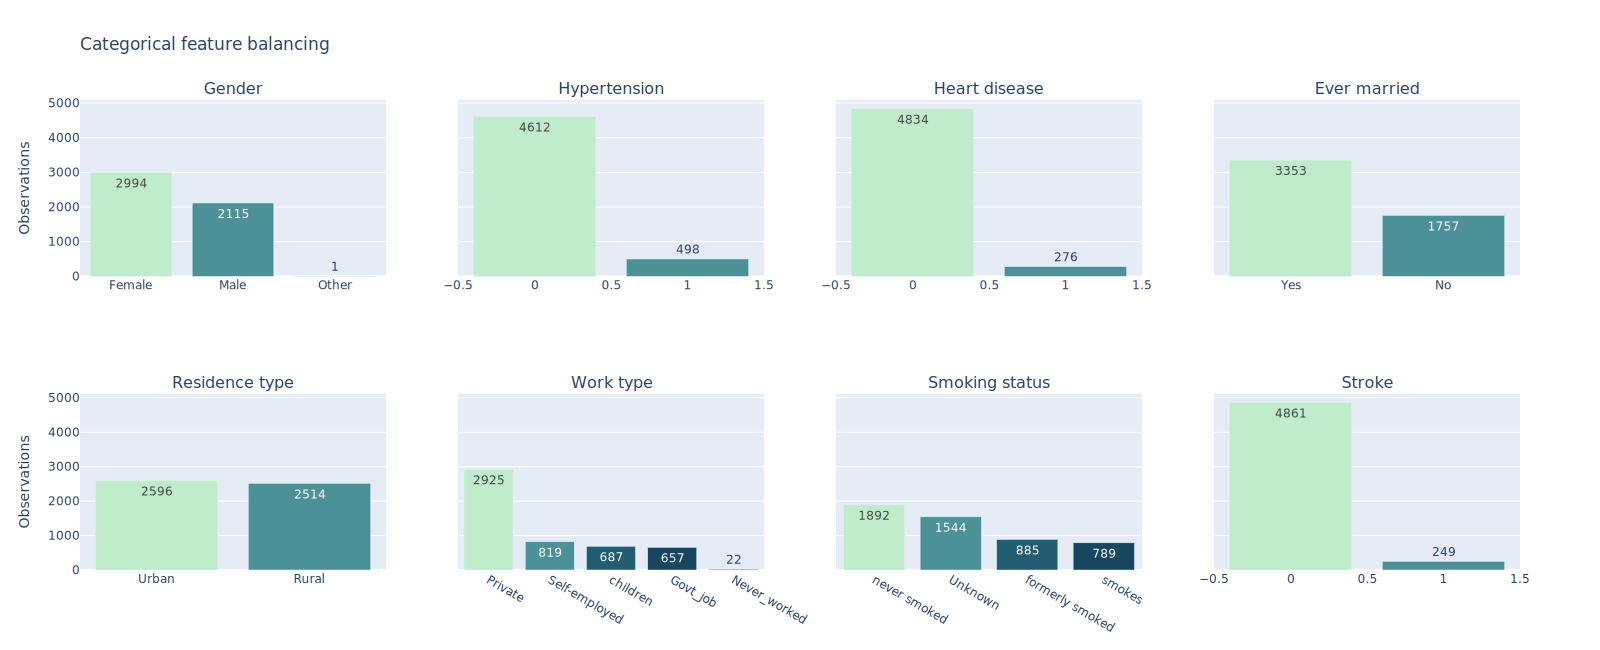

In [99]:
pd_df = pd.DataFrame(df, columns=df.columns)

fig = make_subplots(
    rows=2,
    cols=4,
    subplot_titles=(
        "Gender",
        "Hypertension",
        "Heart disease",
        "Ever married",
        "Residence type",
        "Work type",
        "Smoking status",
        "Stroke",
    ),
    shared_yaxes=True,
)

make_subplot(pd_df, fig, "gender", [1, 1])
make_subplot(pd_df, fig, "hypertension", [1, 2])
make_subplot(pd_df, fig, "heart_disease", [1, 3])
make_subplot(pd_df, fig, "ever_married", [1, 4])

make_subplot(pd_df, fig, "residence_type", [2, 1])
make_subplot(pd_df, fig, "work_type", [2, 2])
make_subplot(pd_df, fig, "smoking_status", [2, 3])
make_subplot(pd_df, fig, "stroke", [2, 4])

fig.update_yaxes(title_text="Observations", row=1, col=1)
fig.update_yaxes(title_text="Observations", row=2, col=1)

fig.update_layout(
    title_text="Categorical feature balancing", height=650, showlegend=False
)

fig.show('svg')

We only have 1 observation coded as neither male or female, and there understandably much more observations of positive cases for the features that are also medical conditions. 

We'll need to account for the imbalance across these medical features, especially stroke when we get to modeling. Precision, f1-score, and recall will be more helpful. Let's compare how much our positive cases line up with established knowledge about strokes. Let's encode our binary and multi-class variables as numerical for later use in the modeling phase of the project. 

Our age feature is pretty much uniform distributions across the range of values represented, with Average glucose level being a more bimodal distribution. BMI skews left, with some long-tail outliers in the upper bound--notably, I had to cast bmi as a float to render this distribution because it is currently encoded as a series of strings in the dataset. Let's fix this detail, along with other quirks in our data that we've flagged so far. 

## Feature engineering 

We'll start by copying the dataframe so that we can begin creating an all-numerical dataframe to model with, while preserving our original dataset to use it as reference further into our analysis and conclusions. Let's modify the dataset according to the details that I've already flagged.

In [66]:
df_num = df.clone()

df_num = df_num.with_columns(
    pl.when(pl.col("bmi") == "N/A").then(np.nan).otherwise(pl.col("bmi")).alias("bmi")
)

df_num = df_num.cast({"bmi": pl.Float32})

df_num = df_num.drop(["id", "row_index"])

### Replace multi-class values 

Next we'll encode the variables that are either binary or multi-class. The encoder mapping key will serve as our guide to interpretting model predictions later. 

In [67]:
encoder_mapping_key = dict()

for col in ["gender", "residence_type", "work_type", "smoking_status", "ever_married"]:
    key = create_encoder_mapping(df_num, col)
    df_num = encode_feature(df_num, col, key)
    encoder_mapping_key[col] = key

Clone model df so that we can input _train and x_test medians for the missing values later

In [68]:
df_modeling = df_num.clone()

df_modeling = df_num.with_columns(
    pl.col("gender").cast(pl.Int64),
    pl.col("age").cast(pl.Int64),
    pl.col("heart_disease").cast(pl.Int64),
    pl.col("ever_married").cast(pl.Int64),
    pl.col("hypertension").cast(pl.Int64),
    pl.col("residence_type").cast(pl.Int64),
    pl.col("work_type").cast(pl.Int64),
    pl.col("smoking_status").cast(pl.Int64),
    pl.col("stroke").cast(pl.Int64),
    pl.col("bmi").round(1),
)

### Impute the missing values in age and bmi

Next we'll impute the missing values in age and bmi, using the median as the substitute value. We'll also tidy up datatypes for our variables by casting them as integers where applicable.

In [69]:
df_num = impute_missing_values(df_num, "age", "median", np.nan)
df_num = impute_missing_values(df_num, "bmi", "median", np.nan)

df_num = df_num.with_columns(
    pl.col("gender").cast(pl.Int64),
    pl.col("age").cast(pl.Int64),
    pl.col("heart_disease").cast(pl.Int64),
    pl.col("ever_married").cast(pl.Int64),
    pl.col("hypertension").cast(pl.Int64),
    pl.col("residence_type").cast(pl.Int64),
    pl.col("work_type").cast(pl.Int64),
    pl.col("smoking_status").cast(pl.Int64),
    pl.col("stroke").cast(pl.Int64),
)

## Correlations

Considering our mix of categorical and numerical variables, we'll have to consider correlations from a number of angles. In this section, we'll use the Chi-Squared Test for categorical-categorical comparison, with Point-Biserial Correlation being our method for binary and numerical variable comparison. Let's first isolate a dataframe of just our binary variables. 

### Point Biserial Correlations

In [70]:
binary_df = df_num[
    [
        "hypertension",
        "heart_disease",
        "ever_married",
        "residence_type",
        "stroke",
    ]
]
continuous_variables = ["age", "bmi", "avg_glucose_level"]

array = np.array(
    [
        pointbiserialr(df_num[col], binary_df[binary_col])[0]
        for col in continuous_variables
        for binary_col in binary_df.columns
    ]
).reshape(len(binary_df.columns), len(continuous_variables))

pb_corr_df = pl.DataFrame(data=array)

pb_corr_df.columns = continuous_variables
pb_corr_df.insert_column(0, pl.Series(binary_df.columns))

,age,bmi,avg_glucose_level
"""hypertension""",0.273174,0.264118,0.645075
"""heart_disease""",-0.015263,0.247198,0.158293
"""ever_married""",0.036916,0.334911,0.000277
"""residence_type""",0.03611,0.174474,0.161857
"""stroke""",0.155068,0.004946,0.131945


Both heart disease has a negative correlation with age in this table, which is interesting and medically untrue. This change in sign is indicative of a confounding variable or set of variables lurking within our data, which we should tease out further before we proceed. Let's group patients by gender and rerun these correlations.  

#### Disaggregating heart disease by gender

In [71]:
gender = df_num["gender"]

male_df_num, female_df_num = segment_df_by_gender(df_num, gender)

male_binary_df, female_binary_df = segment_df_by_gender(binary_df, gender)

female_hd = pointbiserialr(female_df_num["age"], female_binary_df["heart_disease"])[0]
male_hd = pointbiserialr(male_df_num["age"], male_binary_df["heart_disease"])[0]

pl.DataFrame({"Gender": ["female", "male"], "Correlations": [female_hd, male_hd]})

Gender,Correlations
"""female""",0.233366
"""male""",0.303862


The correlations in this table make more sense, namely that there is in fact a positive correlation with age for both genders, and also that this correlation is higher for men in particular. We'll keep gender divided here, using the Chi-Squared test of independence in this next section.

# Chi-Squared Test of Independence

In [72]:
create_chi2_array(female_binary_df)

,hypertension,heart_disease,ever_married,residence_type,stroke
hypertension,0.00000,0.00000,0.00000,0.55104,0.00000
heart_disease,0.00000,0.00000,0.00013,0.57557,0.00000
ever_married,0.00000,0.00000,0.00000,0.53029,0.00000
residence_type,0.00686,0.00000,0.69713,0.00000,0.00003
stroke,0.00000,0.00000,0.00001,0.40946,0.00000


In [73]:
create_chi2_array(male_binary_df)

,hypertension,heart_disease,ever_married,residence_type,stroke
hypertension,0.00000,0.00000,0.00000,0.26616,0.00000
heart_disease,0.00000,0.00000,0.00000,0.59651,0.00000
ever_married,0.00000,0.00000,0.00000,0.59909,0.00000
residence_type,0.00636,0.00258,0.75154,0.00000,0.00008
stroke,0.00000,0.00000,0.00000,0.47240,0.00000


Ignoring the matrix entries on the diagonal, we can see that stroke is not independent of the our features of interest, excluding residence type of course. Also, most of our other variables in these dataframes are not independent of each other neither, so we have some level of multicollinearity that we'll need to address before we get to modeling. Let's move on to outlier detection.

## Detecting outliers
Due to the relative lack of continuous variables in our dataset, it won't really be that helpful to check for univariate outliers--we'll instead focus on multivariate methods to see if any observations stick as outliers when assessed according to all of their features. This will help us better understand the shape of our data, and also makes practical sense since a person's health, and by extension, risk of stroke is made up of a number of factors, not just a single defining feature. 

#### Multivariate outlier detection 
Let's begin by defining x and y, then scaling the data.

In [74]:
x = df_num.drop("stroke").to_numpy() 
x_columns = df_num.drop("stroke").columns
y = df_num["stroke"]


scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

We'll next use K-nearest neighbors to cluster and generate decision scores for the data. From there we can detect outliers in the module and also mark them from the distribution of knn decision scores. 

In [75]:
knn = KNN(contamination=0.1, method="mean", n_neighbors=5).fit(scaled_x)

predicted = pd.Series(knn.predict(scaled_x))
print("Number of KNN outliers = ", predicted.sum())

decision_scores = knn.decision_scores_

knn_outlier_threshold = np.sort(decision_scores)[-203:][0]
outlier_threshold = np.mean(decision_scores) + 2 * np.std(decision_scores)
strong_outlier_threshold = np.mean(decision_scores) + 3 * np.std(decision_scores)

decision_scores_df = pd.DataFrame(decision_scores, columns=["decision_score"])
decision_scores_df["knn_outliers"] = decision_scores_df.decision_score.apply(
    lambda x: x if x > knn_outlier_threshold else np.nan
)
decision_scores_df["std_outliers"] = decision_scores_df.decision_score.apply(
    lambda x: x if x > outlier_threshold else np.nan
)
decision_scores_df["std_strong_outliers"] = decision_scores_df.decision_score.apply(
    lambda x: x if x > strong_outlier_threshold else np.nan
)


num_std_outliers = decision_scores_df[
    decision_scores_df.decision_score >= outlier_threshold
].shape[0]


print(
    f"Number of outliers by deviations from the mean = {num_std_outliers}\n\nOutlier threshold = {outlier_threshold:3f}\nStrong outlier threshold = {strong_outlier_threshold:3f}"
)

Number of KNN outliers =  221
Number of outliers by deviations from the mean = 245

Outlier threshold = 1.612005
Strong outlier threshold = 2.077122


According to K-nearest neighbors clustering, we have a little over 200 outliers by decision score. Using 2 and 3 standard deviations above the mean as our thresholds for what is and isn't an outlier, we can also calculate a rough tiering system for the spread of our data. This isn't too drastic a difference given that only 60 points lie in the region between these two thresholds, but since we have two different possible answers for what we're defining as an outlier here, let's assess this graphically. 

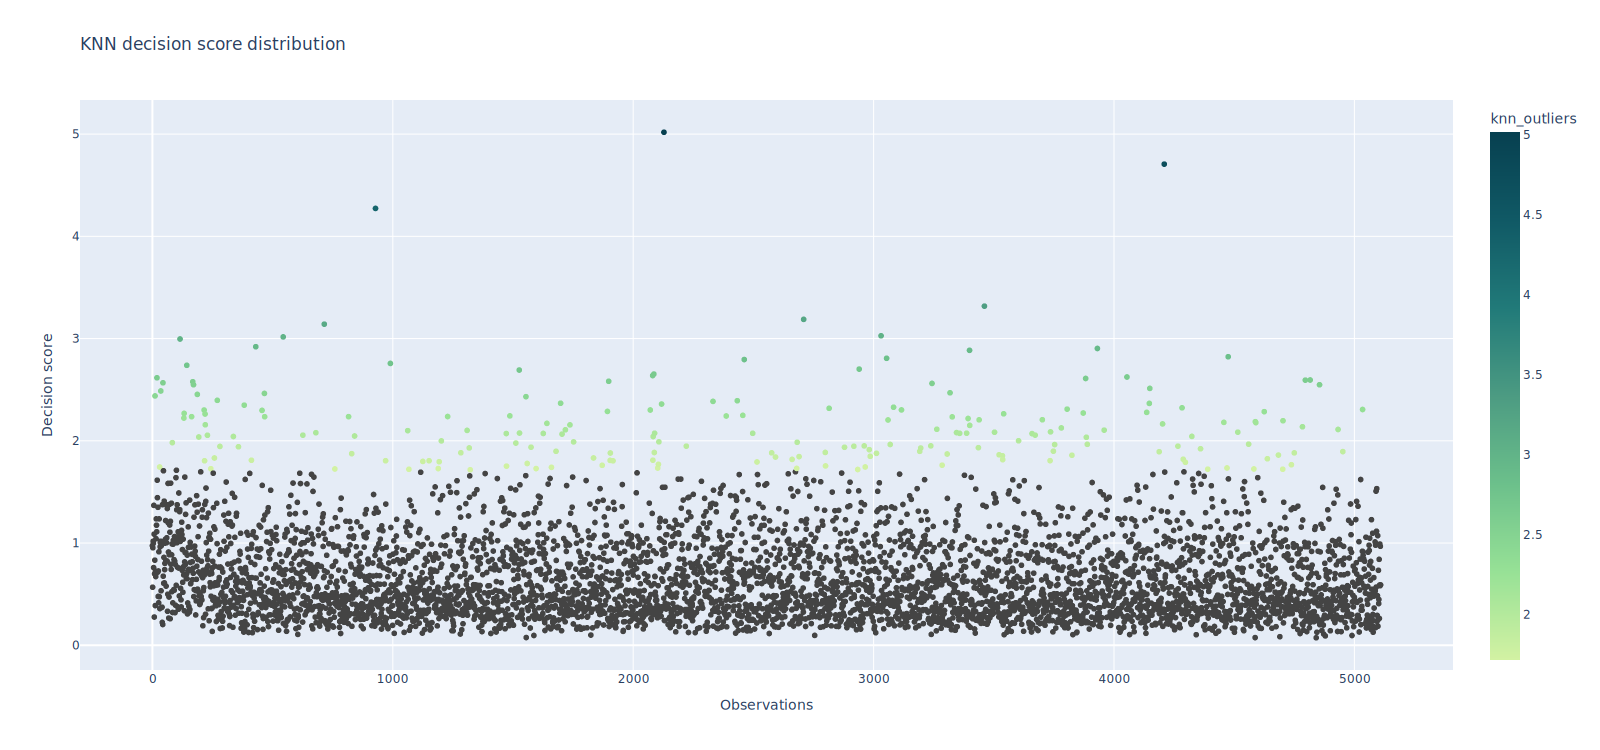

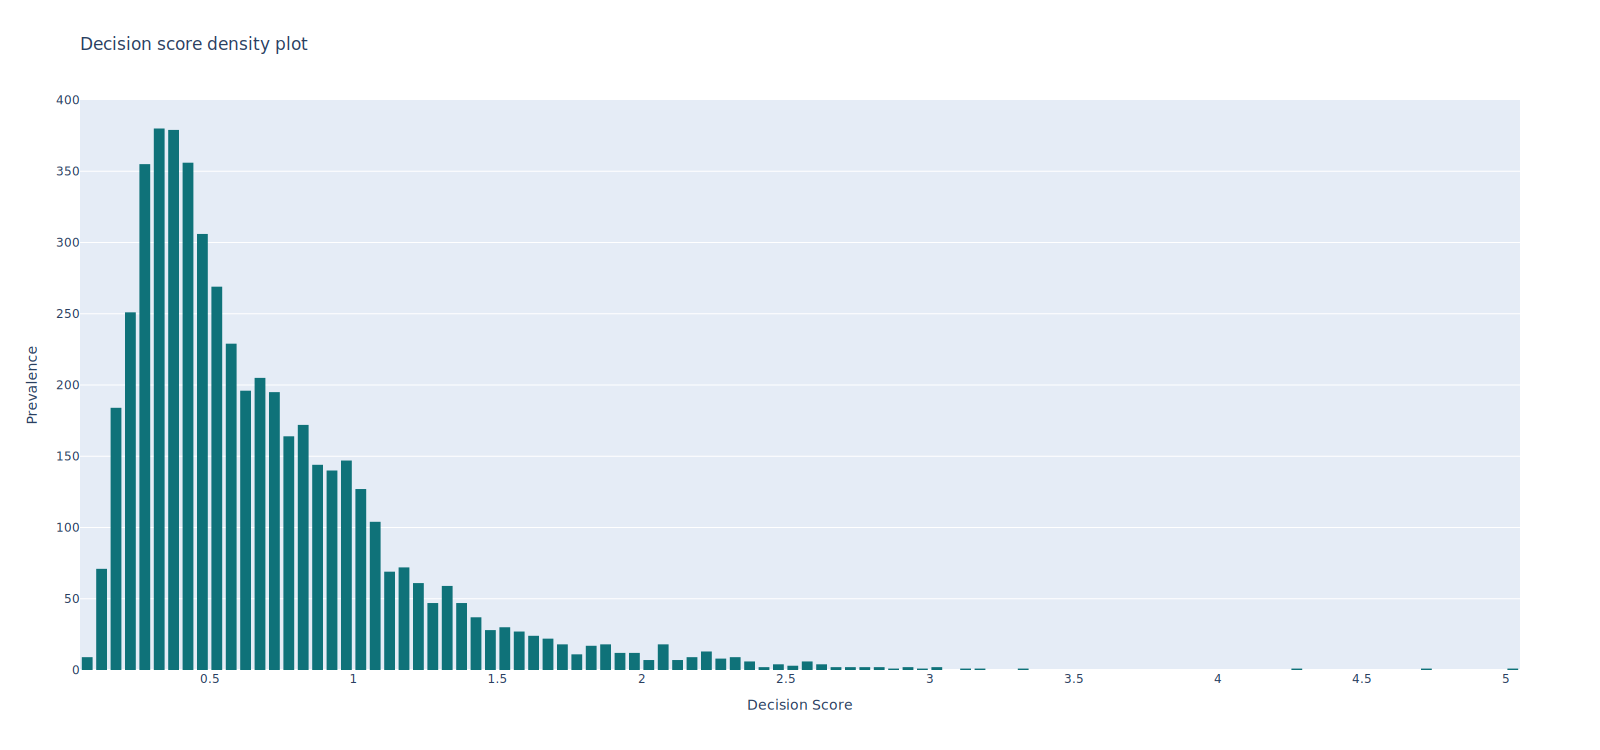

In [100]:
px.scatter(
    decision_scores_df,
    x=decision_scores_df.index,
    y="decision_score",
    color="knn_outliers",
    color_continuous_scale="Emrld",
    title="KNN decision score distribution",
    labels=dict(decision_score="Decision score", index="Observations"),
).show('svg')

fig = px.histogram(
    decision_scores_df,
    x="decision_score",
    title="Decision score density plot",
    color_discrete_sequence=["rgb(15, 114, 121)"],
    nbins=170,
)
fig.update_layout(
    xaxis_title="Decision Score", yaxis_title="Prevalence", bargap=0.25
).show('svg')

The colored-in datapoints on the scatterplot show which datapoints are considered outliers based on our standard deviation criteria, which is a more liberal definition of outlier for this data. This region begins for decision_score >= 2. Though the density of the data cloud is much greater for lower decision scores, we start to see more spread for the data above 2, with the datapoints being much more sparse. We should use the KNN threshold as our dividing line between inliers and outliers from here on out. 

Because this is a healthcare prediction problem, we should not remove these outliers since our data is already imbalanced, and these outliers might have valuable information about our patient pool. But before we move on, let's see if our outlier patients are more likely to have a stroke than the normal population. 

### Outliers and likelihood of stroke

In [77]:
# Designate observation as outlier or inlier based on knn threshold
outlier_df = df_num.to_pandas().copy()
outlier_df["outlier"] = decision_scores_df["knn_outliers"].map(
    lambda x: 1 if x >= knn_outlier_threshold else 0
)

pd.crosstab(
    outlier_df.outlier, outlier_df.stroke, rownames=["outlier"], colnames=["stroke"]
)

stroke,0,1
outlier,,
0,4680,228
1,181,21


Our outliers are far more likely to be negative for stroke, which means they differ from other points along other dimensions, but not along this one. Let's move on to preprocessing for modeling.

# Modeling

Though we are going to be focusing on gradient boosted ensemble modeling and model explainability in this project, we will use a basic sklearn decision tree model to acquaint ourselves with the strengths and weaknesses of our data in a tree classifier context to set a baseline for this model type. To start, we'll split our data into training and testing sets before moving to a grid search of relevant parameters, rated according to recall score performance. From there we'll print out model performance along our performance metrics.

In [78]:
x = df_modeling.drop(["stroke"])
y = df_modeling["stroke"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=15)

x_train = impute_missing_values(x_train, "age", "median", np.nan)
x_train = impute_missing_values(x_train, "bmi", "median", np.nan)
x_test = impute_missing_values(x_test, "age", "median", np.nan)
x_test = impute_missing_values(x_test, "bmi", "median", np.nan)


x_train = scale_x_array(x_train)
x_test = scale_x_array(x_test)

We will judge all the models in our analysis along the metrics found in the scoring dictionary, with our refit metric being the criterion for selecting new models later. The False negative rate is a function that we will use as a callable in our assessment of these models since false negatives are much more costly to patients than false positive results when testing for stroke. Let's divide our data and build out our first decision tree model.

### Decision Tree: setting a baseline

In [79]:
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": int_range(1, 70),
    "class_weight": ["balanced", None],
    "max_features": np.arange(1, len(x_columns)),
}

tree = DecisionTreeClassifier()

pipeline = Pipeline(
    [
        ("rfe", RFECV(tree, step=1, cv=4, scoring="f1")),
        (
            "grid_search",
            RandomizedSearchCV(tree, params, scoring="f1", refit="f1", cv=4),
        ),
    ]
)

pipeline.fit(x_train, y_train)

dt_best_features = classifier_feature_indices = pipeline[0].get_support(indices=True)
dt_best_params = pipeline[1].best_params_


baseline_dt = DecisionTreeClassifier(**dt_best_params)

x_train_rfe, x_test_rfe = restrict_x_columns(x_train, x_test, dt_best_features)

baseline_dt.fit(x_train_rfe, y_train)

y_predict = baseline_dt.predict(x_test_rfe)

models_df = calculate_model_statistics(y_test, y_predict, title="Sklearn decision tree")
models_df

,Sklearn decision tree
f_beta,0.44295
recall (sensitivty),0.53226
precision (specificity),0.17647
accuracy,0.85681
false_negative_rate,0.02269
false_positive_rate,0.12050


Our highest metric is recall, which is good because that is the performance metric that we'd like to lean toward in our model design. That said, precision is very low, which means that fbeta-score low. This spread of scores, along with our false positive rate suggests that our model is over-predicting stroke by a wide margin, which isn't as useful for such an imbalanced dataset. 

We should optimize fbeta score in such a way that we have a reasonable amount of precision for our stroke prediction, but are not compromising recall performance because false negative predictions are costly to patients at risk of stroke. Now that we have an initial decision tree model, let's move on to ensemble modeling . 

# LightGBM 
## Decision tree model selection

We're going to use gradient boosted decision tree ensembles within LightGBM for this section, which we'll follow with a lightgbm model using random forest booster type. To set a baseline, let's use the default model specifications for LGBMClassifier and build from there.

In [80]:
model = LGBMClassifier(verbose=-1, random_state=15, class_weight="balanced")

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

calculate_model_statistics(y_test, y_predict, title="Default LGBM tree")

,Default LGBM tree
f_beta,0.26114
recall (sensitivty),0.27419
precision (specificity),0.18280
accuracy,0.90532
false_negative_rate,0.03521
false_positive_rate,0.05947


The model performed best on accuracy, which is not suprising since our dataset is so biased toward negative observations along the stroke column. We can do better--let's define a hyperparameter space for tuning.

### Hyperparameter Tuning

Let's set the parameter grid for our hyperparameter set. 

In [81]:
params = {
    "boosting_type": ["gbdt"],
    "num_leaves": int_range(2, 64), 
    "max_depth": int_range(-1, 64),
    "n_estimators": np.linspace(35, 150, 50, dtype=int),
    "class_weight": ["balanced"],
}

lgbm = LGBMClassifier(
    objective="binary",
    random_state=global_random_state,
    verbose=-1,
)


boosted_dt_features, boosted_dt_feature_indices, boosted_dt_params = (
    rfe_gridsearch_pipeline(
        lgbm,
        params,
        x_train,
        y_train,
        scoring="f1",
        refit="neg_log_loss",
    )
)

x_train_rfe, x_test_rfe = restrict_x_columns(
    x_train, x_test, boosted_dt_feature_indices
)


tuned_lgbm_dt = LGBMClassifier(**boosted_dt_params, verbose=-1)
tuned_lgbm_dt.fit(x_train_rfe, y_train)
dt_ypred = tuned_lgbm_dt.predict(x_test_rfe)


models_df["LGBM decision tree"] = calculate_model_statistics(y_test, dt_ypred)
models_df

,Sklearn decision tree,LGBM decision tree
f_beta,0.44295,0.50193
recall (sensitivty),0.53226,0.62903
precision (specificity),0.17647,0.17808
accuracy,0.85681,0.84116
false_negative_rate,0.02269,0.01800
false_positive_rate,0.12050,0.14085


Since we have a multiple metrics to inform our model selection within this 600 model pool, we should use a tiered system to choose the best ensemble model. Recall is most important because we'd like to identify any patients that are at high risk of stroke, even if it means that we have false positives within our system. Barring that Johns Hopkins proposes experimental treatments or other costly interventions to patients that our model predicts as being high-risk for stroke, we should consider false negatives much more costly to our model than false positives, so recall is our primary measure of model efficacy. 

Secondarily, we want a reasonable level of precision because stroke is a high-risk medical event that needs to be predicted at a reasonable level of fidelity, else why are we here? 

And lastly, we should consider accuracy because it is helpful once all other models have been seen, even though the incidence of stroke is much lower than not having a stroke when you consider the general population. We'll adopt a model selection filter set that reflects these design considerations in this order. 



Looking at these models side by side, we can see that both our hyperparameter tuning and our model selection criteria helped us arrive at a model that better suits our data and the contours of the client's problem. Let's take a look at gradient boosting via XGBoost in case that might provide us with a little more efficiency.  

## Random forest model selection

#### Hyperparameter tuning

In [82]:
params = {
    "boosting_type": ["rf"],
    "max_depth": int_range(-1, 64),
    "n_estimators": np.linspace(78, 100, 30, dtype=int),
    "feature_fraction": [0.5, 0.7, 0.8, 0.9],
    "class_weight": ["balanced"],
}

lgbm = LGBMClassifier(
    objective="binary",
    metric="false_negative_rate",
    random_state=global_random_state,
    verbose=-1,
)


boosted_rf_features, boosted_rf_feature_indices, boosted_rf_params = (
    rfe_gridsearch_pipeline(
        lgbm,
        params,
        x_train,
        y_train,
        scoring="f1",
        refit="neg_log_loss",
    )
)


x_train_rfe, x_test_rfe = restrict_x_columns(
    x_train, x_test, boosted_rf_feature_indices
)

tuned_lgbm_rf = LGBMClassifier(**boosted_rf_params, verbose=-1)
tuned_lgbm_rf.fit(x_train_rfe, y_train)
rf_ypred = tuned_lgbm_rf.predict(x_test_rfe)

models_df["LGBM random forest"] = calculate_model_statistics(y_test, rf_ypred)
models_df

,Sklearn decision tree,LGBM decision tree,LGBM random forest
f_beta,0.44295,0.50193,0.56517
recall (sensitivty),0.53226,0.62903,0.79032
precision (specificity),0.17647,0.17808,0.15858
accuracy,0.85681,0.84116,0.78638
false_negative_rate,0.02269,0.01800,0.01017
false_positive_rate,0.12050,0.14085,0.20344


We can see here that there is a marked increase F beta score as we move from the sklearn decision tree to the LightGBM decision tree, to the LightGBM random forest. Our models are becoming sequentially more precise, and most importantly, our false negative rate is decreasing as intended. Let's take a look at how well our decision trees and random forest perform within the XGBoost package, and then we'll get into explainability and model intepretation.

# XGBoost
## Decision Tree modeling


Let's train an out-the-box decision tree classifier on our data to see what we get initially.

In [96]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

calculate_model_statistics(y_test, y_predict)

,statistics
f_beta,0.74286
recall (sensitivty),0.74590
precision (specificity),0.71654
accuracy,0.81644
false_negative_rate,0.08493
false_positive_rate,0.09863


Let's tune this classifier and see what performance gains are to be gained. 

## Hyperparameter tuning

In [84]:
params = {
    "objective": ["binary:hinge"],
    "booster": ["gbtree", "dart"],
    "max_leaves": np.linspace(12, 80, 40, dtype=int),
    "max_depth": np.linspace(38, 120, 20, dtype=int),
    "grow_policy": ["depthwise", "lossguide"],
    "eta": np.linspace(0.05, 1, 30),
    "n_estimators": np.linspace(78, 100, 20, dtype=int),
}

xgb = XGBClassifier(booster="gbtree", max_depth=100)

xgbtree_features, xgbtree_feature_indices, xgbtree_params = rfe_gridsearch_pipeline(
    xgb,
    params,
    x_train,
    y_train,
    scoring="f1",
    refit="neg_log_loss",
)

x_train_rfe, x_test_rfe = restrict_x_columns(x_train, x_test, xgbtree_feature_indices)

tuned_xgb = XGBClassifier(**xgbtree_params)
tuned_xgb.fit(x_train, y_train)
y_predict = tuned_xgb.predict(x_test)


models_df["XBoost GB tree ensemble"] = calculate_model_statistics(y_test, y_predict)
models_df

,Sklearn decision tree,LGBM decision tree,LGBM random forest,XBoost GB tree ensemble
f_beta,0.44295,0.50193,0.56517,0.08251
recall (sensitivty),0.53226,0.62903,0.79032,0.08065
precision (specificity),0.17647,0.17808,0.15858,0.10417
accuracy,0.85681,0.84116,0.78638,0.92175
false_negative_rate,0.02269,0.01800,0.01017,0.04460
false_positive_rate,0.12050,0.14085,0.20344,0.03365


This model performs similarly to our LightGBM random forest, and is performing pretty solidly in the false negatives category. Let's see how the XGBoost random forest classifier performs next. 

## XGBoost Random forest ensemble

In [95]:
model = XGBRFClassifier()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

calculate_model_statistics(y_test, y_predict)

,statistics
f_beta,0.77482
recall (sensitivty),0.78689
precision (specificity),0.68085
accuracy,0.80548
false_negative_rate,0.07123
false_positive_rate,0.12329


This model doesn't fare well in any dimension besides accuracy, let's see how much more ground we can make up with proper tuning. 

### Hyperparameter tuning 

In [94]:
params = {
    "colsample_bytree": np.linspace(0.2, 1, 4),
    "subsample": np.linspace(0.2, 1, 8),
    "colsample_bynode": np.linspace(0.2, 1, 9),
    "learning_rate": np.linspace(0.05, 1, 30),
    "n_estimators": np.linspace(78, 100, 30, dtype=int),
}

xgb_rf = XGBRFClassifier(grow_policy="depthwise")

xgb_rf_features, xgb_rf_feature_indices, xgb_rf_params = rfe_gridsearch_pipeline(
    xgb_rf,
    params,
    x_train,
    y_train,
    scoring="f1",
    refit="neg_log_loss",
)

x_train_rfe, x_test_rfe = restrict_x_columns(x_train, x_test, xgb_rf_feature_indices)


xgbrf = XGBRFClassifier(**xgb_rf_params)
xgbrf.fit(x_train_rfe, y_train)
y_predict = xgbrf.predict(x_test_rfe)


models_df["XGBoost random forest"] = calculate_model_statistics(y_test, y_predict)
models_df

,Sklearn decision tree,LGBM decision tree,LGBM random forest,XBoost GB tree ensemble,XGBoost random forest
f_beta,0.44295,0.50193,0.56517,0.08251,0.75121
recall (sensitivty),0.53226,0.62903,0.79032,0.08065,0.76230
precision (specificity),0.17647,0.17808,0.15858,0.10417,0.66429
accuracy,0.85681,0.84116,0.78638,0.92175,0.79178
false_negative_rate,0.02269,0.01800,0.01017,0.04460,0.07945
false_positive_rate,0.12050,0.14085,0.20344,0.03365,0.12877


Our top performing models in terms of false negative rate and fbeta score are the LightGBM models. We'll select these two models for the next phase of our analysis, which will focus on model explainability and transparency.   

# Smote Oversampling 


One way to strengthen our model could be to oversample/undersample on our dataset to rebalance the proportion of positive and negative stroke classes, and then train our classifier on that. We'll use the method put forth in the [original SMOTE paper](https://dl.acm.org/doi/10.5555/1622407.1622416) and then retrain our Lgbm random forest model since that one is our best performing model currently.

In [87]:
x = np.array(df_num.drop("stroke"))
y = np.array(df_num["stroke"])

oversampling = SMOTE(sampling_strategy=0.1)
undersampling = RandomUnderSampler(sampling_strategy=0.5)

steps = [("oversample", oversampling), ("undersample", undersampling)]
pipeline = ImbPipeline(steps=steps)
smote_x, smote_y = pipeline.fit_resample(x, y)

pca = PCA(n_components=smote_x.shape[1])
smote_x = pca.fit_transform(smote_x)

Now that we've resampled our dataset, let's rescale the data and divide it in training and testing sets as we did before. We'll then train our data on a new LightGBM model matching our previous parameter set. 

In [88]:
smote_x = scale_x_array(smote_x)

x_train, x_test, y_train, y_test = train_test_split(
    smote_x, smote_y, stratify=smote_y, random_state=15
)
smote_lgbm = LGBMClassifier(**boosted_rf_params, verbose=-1)
smote_lgbm.fit(x_train, y_train)

y_predict = smote_lgbm.predict(x_test)


pd.concat(
    [models_df["LGBM random forest"], calculate_model_statistics(y_test, y_predict)],
    axis=1,
).rename(
    columns={
        "LGBM random forest": "LGBM random forest v1",
        "statistics": "LGBM random forest v2",
    }
)

,LGBM random forest v1,LGBM random forest v2
f_beta,0.56517,0.80824
recall (sensitivty),0.79032,0.83607
precision (specificity),0.15858,0.62195
accuracy,0.78638,0.77534
false_negative_rate,0.01017,0.05479
false_positive_rate,0.20344,0.16986


The new model output is much, much stronger than our previous model iteration, showing that our undersampling and oversampling did in fact strengthen the predictive power of our model. As a last bit of due diligence before our model selection, we should verify that the LightGBM random forest classifier that we built is indeed the best one out of our 5 models when training on the resampled data. Let's quickly rerun the models and see what we get.

In [89]:
classifier_parameter_list = [
    dt_best_params,
    boosted_dt_params,
    boosted_rf_params,
    xgbtree_params,
    xgb_rf_params,
]

xy_list = [x_train, x_test, y_train, y_test]

smote_models_df = rerun_models(classifier_parameter_list, xy_list)
smote_models_df

,Sklearn decision tree,LGBM decision tree,LGBM random forest,XBoost GB tree ensemble,XGBoost random forest
f_beta,0.75200,0.77724,0.80824,0.63218,0.60231
recall (sensitivty),0.77049,0.79508,0.83607,0.63115,0.59836
precision (specificity),0.61842,0.64667,0.62195,0.64167,0.64035
accuracy,0.76438,0.78630,0.77534,0.75890,0.75342
false_negative_rate,0.07671,0.06849,0.05479,0.12329,0.13425
false_positive_rate,0.15890,0.14521,0.16986,0.11781,0.11233


When compared across all of our classifier iterations, we can see that the LGBM random forest model is still our best performing classifier. We'll give this one to the client, after we've assessed how well this model holds up to medical scrutiny. 

# Model transparency

Given that we're developing a model for a major hospital to use to influence treatment plans and health outcomes for a high-risk medical condition, we should tread carefully recommending a model to the client. Our due diligence not includes model design and training, but also model explainability and transparency. Hospital administrators, doctors, and patients need to all trust that the model we propose is both statistically and medically sound, else we increase risk for patients, doctors, and ultimately Johns Hopkins hospital. 

This section will thus focus on sense-checking our top model so that we can be confident in the implications of its predictions before turning it over to the client.


## LightGBM feature importances

In [90]:
rf_gain, rf_split = lgbm_feature_importances(tuned_lgbm_rf)
scaled_rf_gain, scaled_rf_split = lgbm_feature_importances(tuned_lgbm_rf, scaled=True)

In [91]:
feat_importances = pd.DataFrame(
    sorted(
        zip(
            x_columns,
            rf_gain,
            scaled_rf_gain,
            rf_split,
            scaled_rf_split,
        )
    ),
    columns=[
        "features",
        "random_forest_gain",
        "scaled_random_forest_gain",
        "random_forest_split",
        "scaled_random_forest_split",
    ],
)


feat_importances

,features,random_forest_gain,scaled_random_forest_gain,random_forest_split,scaled_random_forest_split
0,age,71152.97841,847.05927,614,7.30952
1,avg_glucose_level,18291.39519,217.75470,642,7.64286
2,bmi,17126.70385,203.88933,582,6.92857
3,ever_married,6096.47136,72.57704,39,0.46429
4,gender,1568.22375,18.66933,106,1.26190
5,heart_disease,4786.66665,56.98413,76,0.90476
6,hypertension,3242.35427,38.59946,67,0.79762
7,residence_type,1352.55995,16.10190,110,1.30952
8,smoking_status,3153.45018,37.54107,163,1.94048
9,work_type,2959.42295,35.23123,119,1.41667


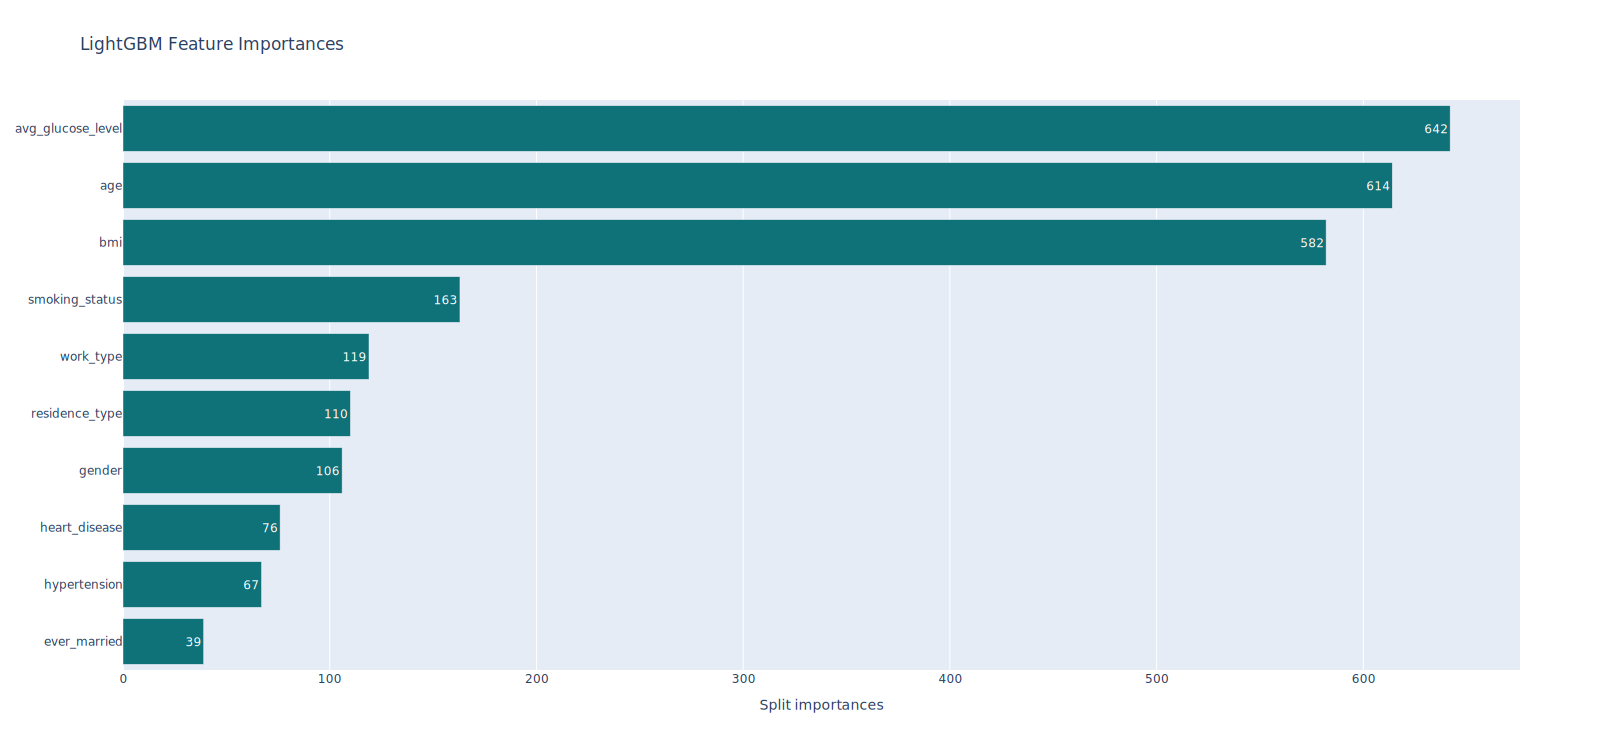

In [98]:
feat_importances = feat_importances.sort_values("random_forest_split", ascending=True)

fig = go.Figure([go.Bar(
        x=feat_importances["random_forest_split"],
        y=feat_importances["features"],
        name="Random Forest",
        orientation="h",
        hovertemplate=feat_importances["features"],
        text=np.round(feat_importances["random_forest_split"], 3),
        marker_color="rgb(15, 114, 121)",
    )])

fig.update_xaxes(title_text="Split importances")
fig.update_layout(title="LightGBM Feature Importances")

fig.show('svg')

We can see here that the top features informing the model's predictions. Now that we know which features our models are using to fork within the forest's underlying decision trees, let's take a look at the information we can glean from the SHAP values in these respective models to dig a little deeper into how the model "understands" these variables.  

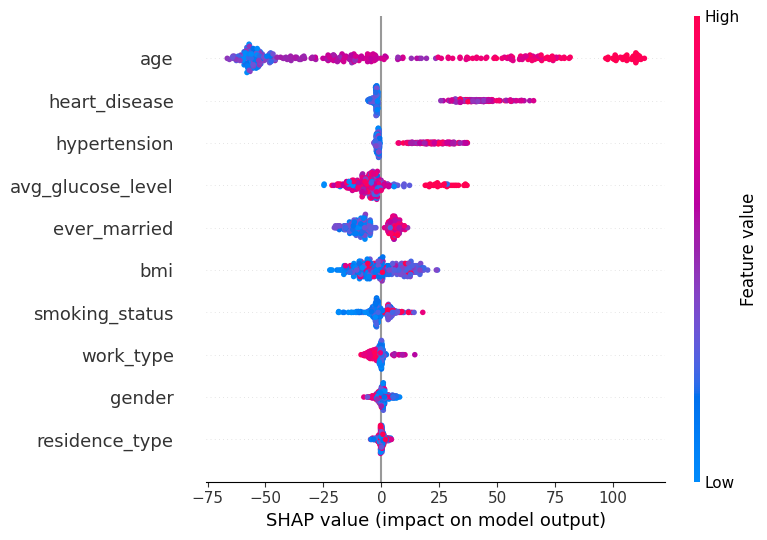

In [93]:
rf_features = pd.DataFrame(
    x_test[:, boosted_rf_feature_indices], columns=boosted_rf_features
)

shap_values = shap.TreeExplainer(tuned_lgbm_rf).shap_values(rf_features)
shap.summary_plot(
    shap_values,
    x_test[:, boosted_rf_feature_indices],
    plot_type="dot",
    plot_size="auto",
    show=False,
    feature_names=boosted_rf_features,
    max_display=rf_features.shape[1]
)

From the SHAP value plot we can see that our most influential features also have the widest, clearest cut spectra. For each of these, the higher the value, the higher the likelhood of a positive prediction in the model. The relationships for the features further down the list aren't as clear however. Some of these less influential features also may contravene the medical literature, which points to there being some utility in refining and expanding our dataset in terms of features and number of observations. 


## Recommendations for further research

To strengthen both the explainability and explanatory power of our model, we recommend prioritizing increasing the number of datapoints that we can train our model, as well the number of features that could be of use. Part of the utility of features like gender, age, and smoking_status is that they directly describe behaviors or patient traits that contribute to a patient's stroke risk, whereas features like work_type, residence_type, and ever_married indirectly point to known risk factors.

Incorporating these risk factors more directly would strengthen the classifiers--instead of residence_type, we could include number of hours a week spent exercising, or data on water pollution or air pollution in their area. Instead of ever_married, we could include datapoints around socialization such as the number of hours spent on the phone or in person with friends and family. Not only would having clearer predictors along these lines strengthen our model, but their incorporation would help flesh out our SHAP values for features further down the list.

Alternatively, we could also request more data for age groups and gender sub-populations of interest in the event that they are more worried about possible stroke patients that are between 50 and 72, children, or women that are peri-menopausal or post-menopausal in particular. From there our team could build different models for these particular subpopulations since risk levels change in relation to a woman's pregnancy and menopausal status, and are also different at different stages of life.

And lastly, simply having more datapoints across all patient subgroups would help us to train effective classifiers without using SMOTE or other imbalanced learning techniques.